# Chapter 2: Taking Earth's Temperature

### Part I: Long-Term Development of Global Earth Temperature Since 1850


The last chapter was entirely focused on the greenhouse gases carbon dioxide and methane and their increasing concentrations in our atmosphere. Next, we will examine the changes in the surface temperature of our Earth, which is also increasing due to the rising GHGs (greenhouse gases). This chapter is divided into three parts, each of which can be accessed as separate notebooks. The individual notebooks deal with the following contents:

1. Long-term development of global Earth temperature since 1850 ([this notebook](#part-one))
2. Comparison between re-analysis and temperature measurements in Europe
3. Current temperature anomalies in different parts of the Earth

<div class="alert alert-block alert-success">
<b>Objective</b> <br>
    This first part compares the global surface temperature from 1850-2022 based on various data sources (you can find an overview in the table below). The aim is to create a time series for each dataset that shows the monthly resolved, averaged surface anomaly over the past ~250 years. Finally, we will present the time series in a common plot.</a>
</div>

| Dataset | Spatial Coverage | Spatial Resolution | Temporal Coverage | Temporal resolution |Provider |
|---------|:-------------:|:------:|:------:|:------:|:------:|
|  NOAAGlobalTempv5 |  Global | 5º x 5º | 1859 - today | Monthly | NOAA |
|  Berkeley Earth |  Global | 1º x 1º | 1850 - today | Monthly | Berkeley Earth |
|  GISTEMPv4 |  Global | 2º x 2º | 1880 - today | Monthly | NASA |
|  HadCRUT5 |  Global | 5º x 5º | 1850 - today | Monthly | Met Office Hadley Centre |
|  ERA5 |  Global | 0.25º x 0.25º | 1950 - today | Monthly | C3S/ECMWF |

Furthermore, we will - as far as accessible - use the land-sea mask created by the respective provider to weight the datasets accordingly. In this part, you can expect the following technical aspects:
- Downloading, opening, and streamlining datasets from various providers
- Working with moderate data volumes (~ 5 GB) using [`dask`](https://www.dask.org/)
- Calculating spatially and temporally correctly weighted averages
- Estimating uncertainties using ensemble members


<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-cams/master?labpath=vis-animations.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-cams/blob/master/vis-animations.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-cams/blob/master/vis-animations.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

#### Getting Set Up

We start by importing all necessary packages:

In [3]:
# Python Standard Libraries
import os
import zipfile
import urllib.request

# Data Manipulation Libraries
import numpy as np
import pandas as pd
import xarray as xr
import regionmask as rm
import dask

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask.diagnostics.progress import ProgressBar

# Climate Data Store API for retrieving climate data
import cdsapi

The following cell ensures a consistent figure layout. If this notebook is run on one of the cloud platforms, the stylesheet is not present by default. You can either upload the file to the cloud server or ignore the next cell. It will not affect the calculation.

In [28]:
plt.style.use(
    "../copernicus.mplstyle"
)  # Set the visual style of the plots; not necessary for the tutorial

Additionally, we instruct dask to avoid the creation of large chunks that may arise in different calculations.

In [29]:
dask.config.set(**{"array.slicing.split_large_chunks": True})

The `regionmask` package allows us to create a land-sea mask for any `xr.DataArray`. We will need this later if a data provider does not provide additional weights for the data.

In [30]:
# Boolean land-sea mask
lsm = rm.defined_regions.natural_earth_v5_0_0.land_110

In the following cells, we determine global parameters that we will repeatedly refer to. Depending on your interest, these can be adjusted as you like. First, we define the `REGIONS` that interest us. Note that most of the underlying data (except ERA5) is relatively coarsely resolved, so the regions should be chosen large enough to ensure sufficient data volume.

In [31]:
# Define regions of interest
# =============================================================================
# Some common regions are defined here: https://climate.copernicus.eu/esotc/2022/about-data#Regiondefinitions
REGIONS = {
    "Global": {"lon": slice(-180, 180), "lat": slice(-90, 90)},
    "Northern Hemisphere": {"lon": slice(-180, 180), "lat": slice(0, 90)},
    "Southern Hemisphere": {"lon": slice(-180, 180), "lat": slice(-90, 0)},
    "Europe": {"lon": slice(-25, 40), "lat": slice(34, 72)},
    "Arctic": {"lon": slice(-180, 180), "lat": slice(66.6, 90)},
}


Here we choose the reference period for calculating the climatology. We use the currently valid 1991-2020.

In [32]:
# Define climatology period
# =============================================================================
REF_PERIOD = {"time": slice("1991", "2020")}

Since we are tapping into different data sources that all come in their format and peculiarities, let's organize the data in folders for a better overview. If these do not exist, they will be created.

In [8]:
file_name = {}  # dictionary containing [data source : file name]

# Add the data sources and file names

# Berkeley Earth
file_name.update({"berkeley": "temperature_berkeley.nc"})  

# GISTEMP
file_name.update({"gistemp_250km": "temperature_gistemp_250km.gz"})  # higher resolution
file_name.update({"gistemp_1200km": "temperature_gistemp_1200km.gz"})  # lower resolution
file_name.update({"gistemp_lsm": "temperature_gistemp_lsm.txt"})  # land sea mask

# HadCRUT
file_name.update({"hadcrut": "temperature_hadcrut.nc"})
file_name.update({"hadcrut_lsm": "temperature_hadcrut_lsm.nc"})  # land sea mask
file_name.update({"hadcrut_members": "temperature_hadcrut_ensemble_members.zip"})  # ensemble members

# ERA5
file_name.update({"era5": "temperature_era5.nc"})

# Create the paths to the files
path_to = {}
for source, file in file_name.items():
    root = "data/{:}/".format(source.split("_")[0])
    path_to.update({source: os.path.join(root, file)})


# Create necessary directories if they do not exist
for file, path in path_to.items():
    os.makedirs(
        os.path.dirname(path), exist_ok=True
    )  # create the folder if not available
    print("{:<15} --> {}".format(file, path))



berkeley        --> data/berkeley/temperature_berkeley.nc
gistemp_250km   --> data/gistemp/temperature_gistemp_250km.gz
gistemp_1200km  --> data/gistemp/temperature_gistemp_1200km.gz
gistemp_lsm     --> data/gistemp/temperature_gistemp_lsm.txt
hadcrut         --> data/hadcrut/temperature_hadcrut.nc
hadcrut_lsm     --> data/hadcrut/temperature_hadcrut_lsm.nc
hadcrut_members --> data/hadcrut/temperature_hadcrut_ensemble_members.zip
era5            --> data/era5/temperature_era5.nc


As we will see, the various data also come with different conventions regarding dimension names and coordinates. We make our work much easier by ensuring at the beginning that all data is in the same format. In our case, we want to streamline datasets as follows:
- Dimension names are (`time`, `lon`, `lat`)
- The monthly resolved time coordinate is in `datetime` format and fixed to the beginning of the month
- The `lon` and `lat` coordinates are sorted by their values
- The `lon` coordinate is defined from -180 to +180º (as opposed to 0 to 360º)

The following function `streamline_data` will take care of these operations.

In [10]:
def streamline_data(da):
    """Streamline the dimensions and coordinates of a DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The DataArray to streamline.
    """

    # Ensure that time coordinate is fixed to the first day of the month
    if "time" in da.coords:
        # if already datetime, just ensure that it is the first day of the month
        if pd.api.types.is_datetime64_any_dtype(da.time):
            da.coords["time"] = da["time"].to_index().to_period("M").to_timestamp()
        # if float, convert to datetime
        elif da.time.dtype == float:
            first_year = int(da.time.values[0])
            time_coord = xr.cftime_range(
                start=f"{first_year}-01-01", periods=da.time.size, freq="MS"
            ).to_datetimeindex()
            da.coords["time"] = time_coord
        # else ¯\_(ツ)_/¯
        else:
            raise ValueError(
                f"Time coordinate is of type {da.time.dtype}, but must be either datetime or float."
            )

    # Ensure that spatial coordinates are called 'lon' and 'lat'
    if "longitude" in da.coords:
        da = da.rename({"longitude": "lon"})
    if "latitude" in da.coords:
        da = da.rename({"latitude": "lat"})

    # Ensure that lon/lat are sorted in ascending order
    da = da.sortby("lat")
    da = da.sortby("lon")

    # Ensure that lon is in the range [-180, 180]
    lon_min = da["lon"].min()
    lon_max = da["lon"].max()
    if lon_min < -180 or lon_max > 180:
        da.coords["lon"] = (da.coords["lon"] + 180) % 360 - 180
        da = da.sortby(da.lon)

    return da

#### Download and streamline the data

Now we are ready to download the various data.

<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
    Please note that the time to request and download the data may vary as it depends on several factors. It typically should take less than 30 minutes though.
</div>

##### NOAA GlobalTemp

[NOAA](https://www.ncei.noaa.gov/products/land-based-station/noaa-global-temp) provides the data in different forms. With the help of the OPeNDAP protocol, loading the data into `xarray` becomes a two-liner. The data comes with an additional `z` dimension, but it only has one level (surface). Since no land-sea weights for the dataset are offered on the website, we utilize the useful functionality of `regionmask` to create a suitable land-sea mask for our dataset.

In [22]:
url_to_noaa = "https://www.ncei.noaa.gov/thredds/dodsC/noaa-global-temp-v5.1/NOAAGlobalTemp_v5.1.0_gridded_s185001_e202306_c20230708T112624.nc"
noaa = xr.open_dataset(url_to_noaa)
noaa = noaa.isel(z=0, drop=True)
noaa = streamline_coords(noaa)
noaa["lsm"] = lsm.mask(noaa).notnull()  # Create a boolean land-sea mask (1=land, 0=sea)
noaa

<xarray.Dataset>
Dimensions:  (time: 2082, lat: 36, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-06-01
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
Data variables:
    anom     (time, lat, lon) float32 ...
    lsm      (lat, lon) bool True True True True ... False False False False
Attributes: (12/66)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           NOAA Merged Land Ocean Global Surface Te...
    summary:                         NOAAGlobalTemp is a merged land-ocean su...
    institution:                     DOC/NOAA/NESDIS/National Centers for Env...
    id:                               gov.noaa.ncdc:C00934 
    naming_authority:                 gov.noaa.ncei 
    ...                              ...
    time_coverage_duration:          P173Y6M
    references:                      Vose, R. S., et al., 2012: NOAAs merged ...
    climatology:                     Climatology is based on 1971-2000 monthl...
    acknowledgment:                  The NOAA Global Surface Temperature Data...
    date_modified:                   2023-07-08T15:26:25Z
    date_issued:                     2023-07-08T15:26:25Z

<div class="alert alert-block alert-warning">
<b>Note</b> <br>
    The mask from regionmask is based on <a gref="https://www.naturalearthdata.com/">NaturalEarth</a> shapefiles and is always boolean (consists only of 0s and 1s). In reality, grid cells (especially on the coast) consist of a certain proportion of water and land, which ideally should be reflected. Therefore, it is advisable to use the official land-sea mask of a dataset if possible. In our application, the differences due to this simplification are negligible.</a>
</div>

##### Berkeley Earth
Next, we download the Berkeley Earth data, available as netCDF.

In [ ]:
url_berkeley = 'https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Gridded/Land_and_Ocean_LatLong1.nc'
urllib.request.urlretrieve(url_berkeley, path_to['berkeley'])

In [24]:
berkeley = xr.open_dataset(path_to["berkeley"])
berkeley = streamline_coords(berkeley)
berkeley

<xarray.Dataset>
Dimensions:      (lon: 360, lat: 180, time: 2079, month_number: 12)
Coordinates:
  * lon          (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat          (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time         (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
Dimensions without coordinates: month_number
Data variables:
    land_mask    (lat, lon) float64 ...
    temperature  (time, lat, lon) float32 ...
    climatology  (month_number, lat, lon) float32 ...
Attributes:
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    history:               20-Apr-2023 07:02:14
    institution:           Berkeley Earth Surface Temperature Project
    land_source_history:   05-Apr-2023 08:20:01
    ocean_source_history:  20-Apr-2023 05:22:16
    comment:               This file contains Berkeley Earth surface temperat...

<div class="alert alert-block alert-info">
<b>Note</b> <br>
    Berkeley Earth is also available in the <a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/insitu-gridded-observations-global-and-regional?tab=overview">Climate Data Store (CDS)</a>, but with values over the ocean masked. If averages over land only are to be calculated, the version there can be used. However, note that the CDS does not provide a land-sea mask.</a>
</div>



##### GISTEMP

[GISTEMP](https://data.giss.nasa.gov/gistemp/) is available in various versions. Here, we opt for the **Gridded Monthly Temperature Anomaly Data** on a regular 2º x 2º grid in netCDF format. In addition to a land mask, we will find different smoothing levels: 250km and 1200km. Both datasets share the same spatial resolution, but the interpolation and smoothing methods. While the 250km smoothing reveals more detailed patterns but lacks information from the oceans, the 1200km version is considerably smoother, providing greater spatial coverage, particularly at the start of the time series when there were globally fewer measuring stations. We adhere to [Simmons et al. (2016)](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.2949), employing the 250km version as our foundation, supplementing missing values with those from the 1200km version.

In [ ]:
url_gistemp_1200km = 'https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz'
url_gistemp_250km = 'https://data.giss.nasa.gov/pub/gistemp/gistemp250_GHCNv4.nc.gz'
url_gistemp_land_sea_mask = 'https://data.giss.nasa.gov/pub/gistemp/landmask.2degx2deg.txt'

urllib.request.urlretrieve(url_gistemp_1200km, 'data/gistemp/temperature_gistemp_1200km.gz')
urllib.request.urlretrieve(url_gistemp_250km, 'data/gistemp/temperature_gistemp_250km.gz')
urllib.request.urlretrieve(url_gistemp_land_sea_mask, 'data/gistemp/temperature_gistemp_land_sea_mask.txt')

In [25]:
with xr.open_dataset("data/gistemp/temperature_gistemp_1200km.gz") as gistemp_1200:
    gistemp_1200 = gistemp_1200["tempanomaly"]
with xr.open_dataset("data/gistemp/temperature_gistemp_250km.gz") as gistemp_250:
    gistemp_250 = gistemp_250["tempanomaly"]
gistemp = gistemp_250.where(gistemp_250.notnull(), other=gistemp_1200)
gistemp_lsm = pd.read_csv(
    "data/gistemp/temperature_gistemp_lsm.txt",
    sep="\s+",
    header=1,
    names=["lon", "lat", "mask"],
)
gistemp_lsm = gistemp_lsm.set_index(["lat", "lon"])
gistemp_lsm = gistemp_lsm.to_xarray()
gistemp = xr.merge([gistemp, gistemp_lsm["mask"]])
gistemp = streamline_coords(gistemp)
gistemp

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, time: 1722)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2023-06-01
Data variables:
    tempanomaly  (time, lat, lon) float32 nan nan nan nan ... 1.15 1.15 1.15
    mask         (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

Let's quickly inspect the differences between the 250km and 1200km version:

Text(0.0, 1.0, 'GISTEMP 1200 km')

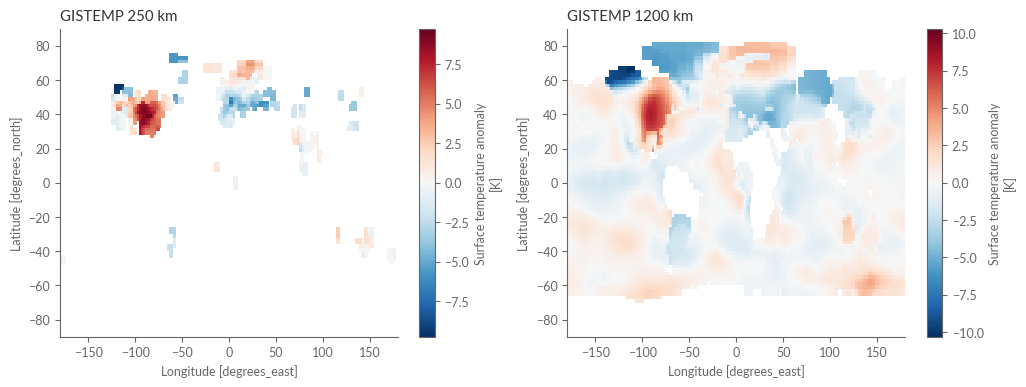

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
gistemp_250.isel(time=0).plot(ax=axes[0])
gistemp_1200.isel(time=0).plot(ax=axes[1])
axes[0].set_title('GISTEMP 250 km')
axes[1].set_title('GISTEMP 1200 km')

##### HadCRUT5

The Met Office offers not only the gridded (mean) HadCRUT5 version but also access to the land-sea mask and the individual ensemble members, upon which the mean is based. Here, we utilise the individual ensemble members to give an estimation of model uncertainty.

In [61]:
url_hadcrut = 'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc'
url_hadcrut_weights = 'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/HadCRUT.5.0.1.0.analysis.weights.nc'
url_hadcrut_ens_members = 'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/HadCRUT.5.0.1.0.analysis.anomalies.1_to_10_netcdf.zip'
urllib.request.urlretrieve(url_hadcrut, path_to['hadcrut'])
urllib.request.urlretrieve(url_hadcrut_weights, path_to['hadcrut_lsm'])
urllib.request.urlretrieve(url_hadcrut_ens_members, path_to['hadcrut_members'])

('data/hadcrut/temperature_hadcrut_ensemble_members.zip',
 <http.client.HTTPMessage at 0x7f9c05e605b0>)

We unzip the ensemble members

In [19]:
with zipfile.ZipFile('data/hadcrut/temperature_hadcrut_ensemble_members.zip') as z:
    z.extractall('data/hadcrut/')

And load and streamline the data

In [21]:
with xr.open_dataset(path_to["hadcrut"]) as hadcrut:
    pass
with xr.open_dataset(path_to["hadcrut_lsm"]) as hadcrut_weights:
    pass
hadcrut_members = xr.open_mfdataset(
    "data/hadcrut/*analysis*.nc", combine="nested", concat_dim="realization"
)
hadcrut_members = hadcrut_members.load()  # load members into memory
hadcrut = xr.Dataset(
    {
        "mean": hadcrut["tas_mean"],
        "weights": hadcrut_weights["weights"],
        "ensemble": hadcrut_members["tas"],
    }
)
hadcrut = streamline_coords(hadcrut)
hadcrut

<xarray.Dataset>
Dimensions:      (time: 2082, lat: 36, lon: 72, realization: 10)
Coordinates:
  * time         (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-06-01
  * lat          (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon          (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * realization  (realization) int64 1 10 2 3 4 5 6 7 8 9
Data variables:
    mean         (time, lat, lon) float64 ...
    weights      (time, lat, lon) float64 ...
    ensemble     (realization, time, lat, lon) float64 nan nan ... 0.3561 0.3569

<div class="alert alert-block alert-warning">
<b>Note</b> <br>
    The uncertainty, based on individual model members, does <b>not</b> take into consideration the lack of precision in the spatial mean due to limited spatial coverage, a factor that is particularly significant at the start of the time series.</a>
</div>



<div class="alert alert-block alert-info">
<b>Note</b> <br>
    In total, the HadCUT5 model relies on 200 ensemble members. However, we're only using the first 20 here to cut down on loading and computing times. The workflow remains unaffected by this. Nonetheless, it should be noted that utilising a small subset of members to gauge uncertainty generally results in an underestimation.</a>
</div>



##### ERA5 reanalysis

Now, we load ERA5 from the [Climate Data Store (CDS)](https://doi.org/10.24381/cds.f17050d7) using the `cdsapi`, including the land-sea mask. To access the CDS programaticcaly, we'll have to provide our CDS API key. If you're new to the CDS be sure to work through the [CDS tutorial](https://ecmwf-projects.github.io/copernicus-training-c3s/cds-tutorial.html) first.

In [49]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##################################'

In [ ]:
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
  'reanalysis-era5-single-levels-monthly-means',
  {
    'format': 'netcdf',
    'product_type': 'monthly_averaged_reanalysis',
    'variable': ['2m_temperature', 'land_sea_mask'],
    'year': list(range(1950, 2023)),
    'month': list(range(1, 13)),
    'time': '00:00',
    # 'grid': [0.25, 0.25],
  },
  path_to['era5']
)

Here, we must consider that, in contrast to all other datasets, which are already provided as anomalies in °C, ERA5 is provided in absolute temperatures in Kelvin. While the unit is irrelevant for the calculation of anomalies, an absolute global average in °C is more easily interpretable than in Kelvin. In the following, we open the data and convert the temperatures from Kelvin to Celsius.

In [33]:
with xr.open_mfdataset(path_to["era5"]) as era5:
    # convert from Kelvin to Celsius
    era5["t2m"] = era5["t2m"] - 273.15
era5 = streamline_coords(era5)
era5

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 721, time: 876)
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2022-12-01
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(876, 27, 720), meta=np.ndarray>
    lsm      (time, lat, lon) float32 dask.array<chunksize=(876, 27, 720), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-18 21:45:16 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

#### Calculation of Spatial Averages

Next, we calculate the time series of spatial averages for each dataset. Two factors must be considered:

- Due to the given representation of the data on a regular longitude-latitude grid, the areas towards the poles are inflated.
- For averages over land, the grid points must be weighted according to the land proportion.

In the following, we define a function for the calculation of the spatial average, taking into account these two factors. By including an additional parameter for the `region`, we can directly calculate the average for subregions. By specifying a land-sea mask, the optional parameter `land_mask` allows us to compute the average only over land.

In [34]:
def weighted_spatial_average(da, region, land_mask=None):
    """Calculate the weighted spatial average of a DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The DataArray to average.
    weights : xr.DataArray, optional
        A DataArray with the same dimensions as `da` containing the weights.
    """
    da = da.sel(**region)

    # Area weighting: calculate the area of each grid cell
    weights = np.cos(np.deg2rad(da.lat))

    # Optionally, apply land-sea mask
    if land_mask is not None:
        land_mask = land_mask.sel(**region)
        # fill up nan values with 0 so that they don't affect the weighted mean
        land_mask = land_mask.fillna(0)
        # combine land mask with weights
        weights = weights * land_mask

    # Compute the weighted mean
    return da.weighted(weights).mean(("lat", "lon"))

With the defined function, we can now iterate through our various datasets. For this, we need to define only two dictionaries, which associate the data with the corresponding land-sea masks.

In [35]:
temps = {
    "HadCRUT": hadcrut["mean"],
    "HadCRUT_ensemble": hadcrut["ensemble"],
    "Berkeley": berkeley["temperature"],
    "GISTEMP": gistemp["tempanomaly"],
    "NOAA": noaa["anom"],
    "ERA5": era5["t2m"],
}
land_masks = {
    "HadCRUT": hadcrut["weights"],
    "HadCRUT_ensemble": hadcrut["weights"],
    "Berkeley": berkeley["land_mask"],
    "GISTEMP": gistemp["mask"],
    "NOAA": noaa["lsm"],
    "ERA5": era5["lsm"],
}


We now iterate over all datasets to calculate the mean temperatures, e.g., in the Arctic (over land). By changing the `region`, averages for any other pre-defined region can be calculated.

In [36]:
region = "Arctic"

temp_evolution = {}
for source in temps:
    spatial_average = weighted_spatial_average(
        temps[source], REGIONS[region], land_masks[source]
    )
    # Use dask for the high-resolution ERA5 data
    with ProgressBar():
        temp_evolution[source] = spatial_average.compute()
temp_evolution = xr.Dataset(temp_evolution)
temp_evolution

[########################################] | 100% Completed | 151.86 s


<xarray.Dataset>
Dimensions:           (time: 2082, realization: 10)
Coordinates:
  * time              (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-06-01
  * realization       (realization) int64 1 10 2 3 4 5 6 7 8 9
Data variables:
    HadCRUT           (time) float64 -1.962 -0.6203 -1.374 ... 2.094 2.331 1.309
    HadCRUT_ensemble  (realization, time) float64 -2.02 -0.3699 ... 2.168 1.19
    Berkeley          (time) float64 -1.055 0.07 0.6092 0.2195 ... nan nan nan
    GISTEMP           (time) float64 nan nan nan nan ... 2.965 2.102 2.159 1.558
    NOAA              (time) float64 -1.497 -0.4415 -1.032 ... 1.795 2.349 1.141
    ERA5              (time) float32 nan nan nan nan nan ... nan nan nan nan nan

All datasets except ERA5 are already provided in terms of anomalies. However, the reference period for each dataset is different, so the anomalies cannot be directly compared with each other. By calculating anomalies relative to 1991-2020, we align all datasets to this period.

In [37]:
# Show anomalies with respect to the 1991-2020 climatology
temp_evolution = temp_evolution - temp_evolution.sel(REF_PERIOD).mean("time")

To also view the temperature increase relative to the pre-industrial era (here, freely defined as 1850-1900), we calculate the reference value as the average of the anomalies of all datasets within this time frame (excluding the HadCRUT ensemble members; these are already represented by the HadCRUT ensemble mean).

In [38]:
anom_1850_1900 = temp_evolution.drop_vars("HadCRUT_ensemble").sel(
    time=slice("1850", "1900")
)
mean_1850_1900 = anom_1850_1900.to_array().mean()

For better illustration, we also calculate the 60-month (5-year) centred moving average of the time series, so that inter-annual climate fluctuations (e.g., due to ENSO) are reduced.

In [39]:
temp_evolution_smooth = temp_evolution.rolling(time=60, center=True).mean()

Lastly, we calculate the uncertainty of the HadCRUT model as the minimum/maximum value of all members for each time step.

In [40]:
confidence_interval = temp_evolution_smooth["HadCRUT_ensemble"].quantile([0.0, 1.0], dim="realization")

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Et voilà! Now all the time series can be compared in a single graph:

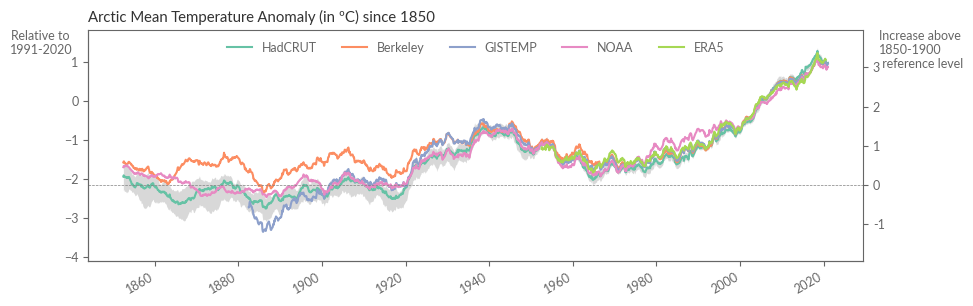

In [41]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
temp_evolution_smooth["HadCRUT"].plot(ax=ax, label="HadCRUT")
temp_evolution_smooth["Berkeley"].plot(ax=ax, label="Berkeley")
temp_evolution_smooth["GISTEMP"].plot(ax=ax, label="GISTEMP")
temp_evolution_smooth["NOAA"].plot(ax=ax, label="NOAA")
temp_evolution_smooth["ERA5"].plot(ax=ax, label="ERA5")
ax.fill_between(
    confidence_interval.time,
    confidence_interval.sel(quantile=0.0),
    confidence_interval.sel(quantile=1.0),
    color=".7",
    alpha=0.5,
    lw=0,
    zorder=-1,
)
ax.legend(ncols=6, frameon=False, loc="upper center")


ax2.spines["right"].set_visible(True)
ax2.spines["top"].set_visible(True)
ax.xaxis.set_major_locator(mdates.YearLocator(20))

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title(f"{region} Mean Temperature Anomaly (in ºC) since 1850")
ax.text(
    -0.02,
    1,
    "Relative to \n1991-2020",
    rotation=0,
    ha="right",
    va="top",
    transform=ax.transAxes,
)
ax.text(
    1.02,
    1,
    "Increase above \n1850-1900\n reference level",
    rotation=0,
    ha="left",
    va="top",
    transform=ax.transAxes,
)
ax.axhline(mean_1850_1900, color=".5", lw=0.5, ls="--")

yticks = np.arange(-10, 10, 1)
ax2_yticks = yticks + mean_1850_1900.item()
ax2.set_yticks(ax2_yticks)
ax2.set_yticklabels(yticks)
ax.set_ylim(-4.1, 1.8)
ax2.set_ylim(-4.1, 1.8)

plt.show()

#### Understanding Model Discrepancies

We see that all datasets since the middle of the last century exhibit a very high degree of agreement. If we want to quantify the degree of agreement, we can, for example, calculate the spread, i.e., the maximum minus minimum value, for each time step. This makes it clear that the differences between the datasets generally increase the further we look back into the past.

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


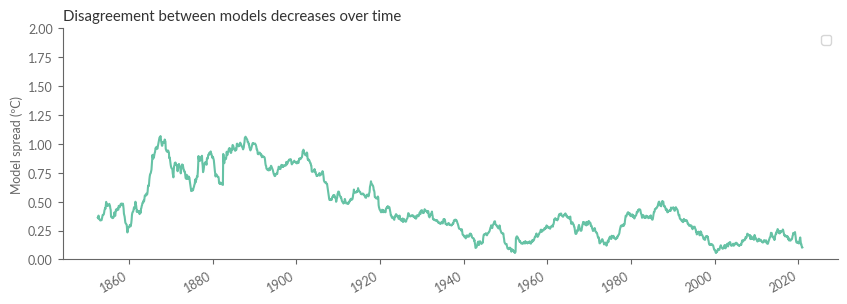

In [47]:
qs = temp_evolution_smooth.drop_vars(["HadCRUT_ensemble"]).to_array().quantile([0, 1], 'variable')
plt.figure(figsize=(10, 3))
qs.diff('quantile').plot.line(x='time')
plt.ylim(0, 2.0)
plt.ylabel("Model spread (ºC)")
plt.xlabel("")
plt.legend([])
plt.title("Disagreement between models decreases over time")
plt.show()

This observation has many reasons, but a crucial factor is the low number of observation stations and the resulting limited spatial coverage the further back in time we go. Let's take BerkeleyEarth as an example:

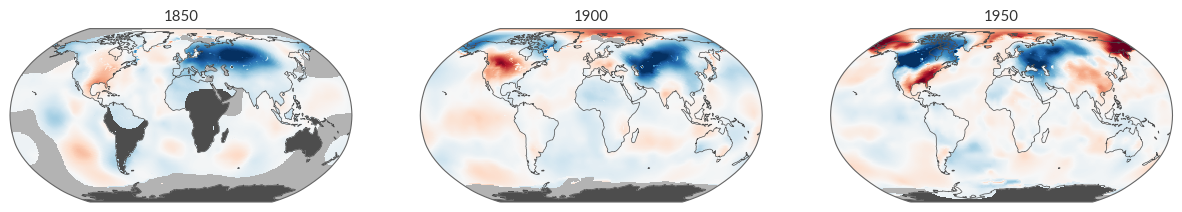

In [46]:
# Note that the farer back in time we go, the less of the globe is covered by the data illustrating the limited in-situ measurements available in the prior centuries.
fig = plt.figure(figsize=(15, 5))
ax = [plt.subplot(1, 3, i+1, projection=ccrs.Robinson()) for i in range(3)]
kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-8, vmax=8, add_colorbar=False)
berkeley['temperature'].sel(time='1850-01').plot(ax=ax[0], **kwargs)
berkeley['temperature'].sel(time='1900-01').plot(ax=ax[1], **kwargs)
berkeley['temperature'].sel(time='1950-01').plot(ax=ax[2], **kwargs)
for a in ax:
    a.coastlines(lw=.5, color='.3')
    a.add_feature(cfeature.LAND, lw=.5, color='.3')
    a.add_feature(cfeature.OCEAN, lw=.5, color='.7')
    a.set_global()
    a.set_title('')
ax[0].set_title('1850', loc='center')
ax[1].set_title('1900', loc='center')
ax[2].set_title('1950', loc='center')
plt.show()

In conclusion, it should be mentioned once more that the displayed uncertainty of the HadCRUT model is too low. As previously explained, this is partly due to the small number of ensemble members considered. But even with all ensemble members, the uncertainty would still be too low, especially for the beginning of the time series, as it does not take into account the limited  spatial coverage.

#### Final Words

Congratulations! Now that we've waded together through the data swamp, let's finally address one last question: How warm is it on Earth?

If we take the absolute temperatures from ERA5 as our basis, we can, for example, calculate the spatial average for the reference period (1991-2020) in our desired region using our defined function. We then calculate the temporal average over the monthly averages using a weighted average that weights the individual monthly values by the number of days.

In [48]:
# Taking Earth's mean temperature
region = "Europe"  # <--- define the region here
land_mask = era5["lsm"]  # <--- define the land mask here


clim_temp_era5 = era5["t2m"].sel(REF_PERIOD)  # consider the reference period
clim_temp_era5 = weighted_spatial_average(
    clim_temp_era5, REGIONS[region], land_mask=land_mask
)

with ProgressBar():
    clim_temp_era5 = clim_temp_era5.compute()  # compute the result

# Weighted temporal mean taking into account the number of days in each month over climatology period
dim = clim_temp_era5.time.dt.days_in_month
clim_temp_era5 = (clim_temp_era5 * dim).sum() / dim.sum()


[########################################] | 100% Completed | 124.11 s


In [45]:
print(f'{region} mean temperature between 1991 and 2020 was {clim_temp_era5.item():.1f} °C.')

Europe mean temperature between 1991 and 2020 was 9.3 °C.


#### Summary

That's it! In this tutorial we focused on analyzing the long-term changes in Earth's surface temperature from 1850 to 2022, in light of increasing greenhouse gases. We learned to download, streamline, and work with various datasets using tools like `dask` and `regionmask`. We also explored how to calculate weighted averages both in space in time. As a main output, we created a plot to represent the monthly resolved, averaged surface anomalies from various data sources over the past ~250 years. Finally, we briefly touched upon reasons for the observed differences among models.

Thank you for taking the time for this tutorial! Don't forget to check out the next part of the trilogy, where we will verify the ERA5 surface temperatures in Europe for accuracy by comparing them with real observation data.